In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("trimmed.csv")

In [3]:
print(data.head())

   Unnamed: 0  age  juv_fel_count  juv_misd_count  juv_other_count  \
0           1   27              0               0                1   
1           2   41              0               0                0   
2           7   54              0               0                0   
3           8   54              0               0                0   
4           9   54              0               0                0   

   priors_count c_charge_degree                  c_charge_desc  is_recid  \
0            18            (F3)  Grand Theft in the 3rd Degree         0   
1            11            (F3)             Felony Petit Theft         1   
2            10            (F3)          Possession of Cocaine         0   
3            10            (F3)          Possession of Cocaine         0   
4            10            (F3)          Possession of Cocaine         0   

   prison_length  
0            510  
1            391  
2            231  
3            275  
4           1061  


In [4]:
data_filtered = data[["age","priors_count","c_charge_degree","is_recid","prison_length"]]

In [5]:
print(data_filtered.head())

   age  priors_count c_charge_degree  is_recid  prison_length
0   27            18            (F3)         0            510
1   41            11            (F3)         1            391
2   54            10            (F3)         0            231
3   54            10            (F3)         0            275
4   54            10            (F3)         0           1061


In [6]:
def filter(data):
    first = data.groupby('c_charge_degree').c_charge_degree.count()
    selected = first[first > 4]
    cols = selected.index.values.tolist()
    data = data[data["c_charge_degree"].isin(cols)]
    print(data.head(10))
    return data


In [7]:
data_filtered = filter(data_filtered)

   age  priors_count c_charge_degree  is_recid  prison_length
0   27            18            (F3)         0            510
1   41            11            (F3)         1            391
2   54            10            (F3)         0            231
3   54            10            (F3)         0            275
4   54            10            (F3)         0           1061
5   54            10            (F3)         0            518
6   54            10            (F3)         0            164
7   54            10            (F3)         0            418
8   28             5            (F3)         0           2066
9   38            18            (F1)         1           1062


In [8]:
k = 10
from sklearn.preprocessing import MinMaxScaler

def algo(row,data):
    charge_deg = row["c_charge_degree"]
    #print(row)
    relevant_data = data[data["c_charge_degree"] == charge_deg]
    
    scaler = MinMaxScaler()
    relevant_data[["age","priors_count"]] = scaler.fit_transform(relevant_data[["age","priors_count"]])
    
    sample = relevant_data.copy()
    sample["age"] = row["age"]
    sample["priors_count"] = row["priors_count"]
    
    sample[["age","priors_count"]] = scaler.transform(sample[["age","priors_count"]])

    relevant_data["dist"] = abs(sample["age"] - relevant_data["age"]) + abs(sample["priors_count"] - relevant_data["priors_count"])
    
    relevant_data = relevant_data.sort_values("dist")
    
    relevant_data = relevant_data.iloc[1:k+1,]
    relevant_data = relevant_data[["is_recid","prison_length"]]
    relevant_data["prison_length"] = relevant_data["prison_length"] // 365 + 1

    return relevant_data
    

In [9]:
from collections import OrderedDict
def kyrie(row,data):
    relevant_data = algo(row,data)
    dic = {}
    #(sentence length: (num_recid,count))
    for i in range(relevant_data.shape[0]):
        p_length = relevant_data.iloc[i]["prison_length"]
        is_recid = relevant_data.iloc[i]["is_recid"]
        
        if p_length not in dic:
            dic[p_length] = (is_recid,1)
        else:
            tup1 = dic[p_length][0] + is_recid
            tup2 = dic[p_length][1] + 1
            dic[p_length] = (tup1,tup2)
    dic2 = {}
    for length in dic:
        dic2[length] = dic[length][0] / dic[length][1]
    
    dic2 = OrderedDict(sorted(dic2.items()))
    dic2 = dict(dic2)
    min_sentence = 0
    min_val = float('inf')
    for key in dic2:
        if dic2[key] < min_val:
            min_val = dic2[key]
            min_sentence = key
    
    
    return dic2,min_sentence,min_val

In [10]:

recid_0 = []
min_sent_0 = 0
act_sent_0 = 0
min_sent_1 = 0
act_sent_1 = 0
recid_1 = []
for i in range(100):
    ind = int(np.random.rand()*len(data_filtered))

    mapper,min_sentence,min_val = kyrie(data_filtered.iloc[ind],data_filtered)
    actual_sent = data_filtered.iloc[ind]["prison_length"]
    diff = min_sentence - actual_sent
    if data_filtered.iloc[ind]["is_recid"] == 1:
        recid_1.append(diff)
        min_sent_1 += min_sentence
        act_sent_1 += actual_sent
    else:
        recid_0.append(diff)
        min_sent_0 += min_sentence
        act_sent_0 += actual_sent   

print(np.mean(recid_0))
print(np.mean(recid_1))
print("Act sent 0", act_sent_0/len(recid_0))
print("Predicted sent_0",365*min_sent_0/len(recid_0))
print("recid 1 below")
print("Act_sent_1", act_sent_1/len(recid_1))
print("Predicted sent 1",365*min_sent_1/len(recid_1))

# print(mapper)
# print(min_sentence)
# print(min_val)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

-714.2592592592592
-922.4347826086956
Act sent 0 716.1296296296297
Predicted sent_0 682.6851851851852
recid 1 below
Act_sent_1 924.4130434782609
Predicted sent 1 722.0652173913044


In [11]:
x = []
y = []
def plot(dictionary):
    for key in dictionary:
        val = dictionary[key]
        x.append(key)
        y.append(val)
    
    z = np.polyfit(x,y,2)
    f = np.poly1d(z)
    x_2 = np.linspace(min(x),max(x),20)
    y_2 = f(x_2)
    
    sns.set_style("darkgrid")
    plt.plot(x,y,label = "Real Data")
    plt.plot(x_2,y_2,label = "Fitted Data")
    plt.xlabel("Sentence Length (Years)")
    plt.ylabel("Probability of Recidivism")
    plt.legend()
    filename = str(ind) + ".png"
    plt.savefig(filename)

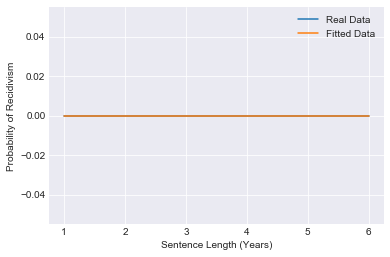

In [12]:
plot(mapper)

In [13]:
def plot_hist(x):
    sns.set_style("darkgrid")
    plt.hist(x,bins = "auto")